In [ ]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline. 
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# S0 Data Generation
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

## Prep for 3D data generation
X = np.empty((m, 3))

## The "Ring"
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2

## The "Tilt"
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

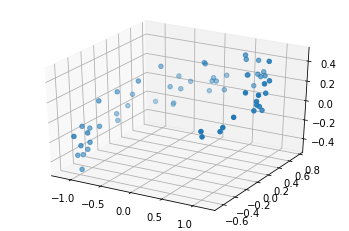

In [ ]:
# Visualize the data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

In [ ]:
# S1: Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, whiten = True, random_state=0)
X2D = pca.fit_transform(X)

print("Before transfer, the dimension is:", X.shape[1], "\n",
      "After transfer, the dimension is:", X2D.shape[1])

Before transfer, the dimension is: 3 
 After transfer, the dimension is: 2


In [ ]:
# S2: Finding the "explained variance", or the information kept after transfer
pca.explained_variance_ratio_
# info_kept = np.sum(pca.explained_variance_ratio_)
# print(info_kept)
# 1 - info_kept

array([0.84248607, 0.14631839])

In [ ]:
# S3: Finding the transfer
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [ ]:
# Suppose the original variables are X1, X2, X3, correspondingly
## Then: 
## X1_new = -0.936X1 -0.299X2 - 0.185X3
## X2_new = 0.340X1 - -0.901X2 - 0.268X3

## Facial Recognition


### The Wild Face Dataset
The Wild Face Dataset is a collection of pictures of famous people over the internet. It has altogether 5749 people and 13233 pictures. Each picture has 5828 features, and each feature is a real number between 0 and 255. 

In [ ]:
# Load the Data
## For the first time, the code may take several minutes to run
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [ ]:
# Check features
print("keys:", people.keys())
print("target shape:", people.target.shape)
print("data shape:", people.data.shape)
print("image shape:", people.images.shape)
print('target_names shape:', people.target_names.shape)
# 3023 pictures, each picture described by 87*65=5655 features. 62 unique people (classes)

keys: dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
target shape: (3023,)
data shape: (3023, 5655)
image shape: (3023, 87, 65)
target_names shape: (62,)


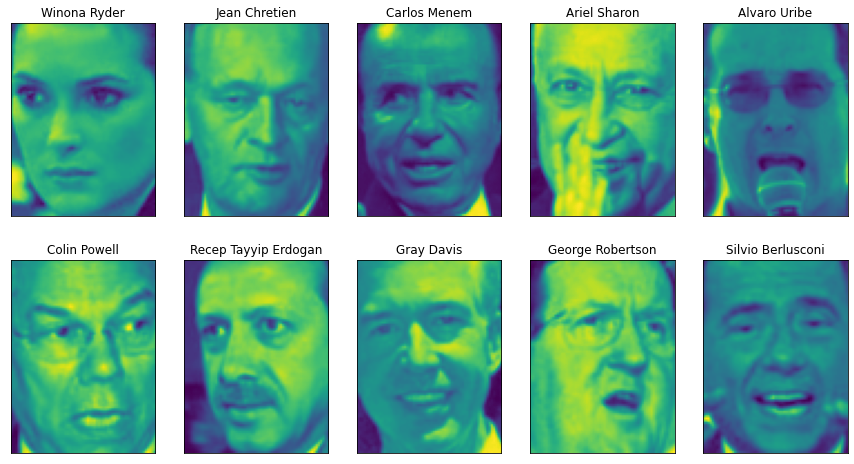

In [ ]:
# Check a couple of pictures

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
    
    
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap='viridis')
    ax.set_title(people.target_names[target])

In [ ]:
counts=np.bincount(people.target)
# counts

In [ ]:
# Data for Analysis
X = people.data
y = people.target

from sklearn.model_selection import train_test_split

# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

### Nearest Neighbor Classification with PCA


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# build a KNeighborsClassifier with using one neighbor:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn is:", knn.score(X_test, y_test))

Test set score of 1-nn is: 0.3253968253968254


### Scaling Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1))

# Train our scaler
minmax.fit(X_train)

# Get scaled variables
X_train_scaled = minmax.transform(X_train)
X_test_scaled = minmax.transform(X_test)
# X_train_scaled

In [ ]:
# We can also do the scaling manually. The result might differ slightly
X_manual_train = X_train/255
# X_manual_train

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
print("Test set score of 1-nn is:", knn.score(X_test_scaled, y_test))

Test set score of 1-nn is: 0.33994708994708994


### PCA


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100,  whiten=True, random_state=0)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape:", X_train_pca.shape)

X_train_pca.shape: (2267, 100)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: ", knn.score(X_test_pca, y_test))

Test set accuracy:  0.45105820105820105


In [ ]:
# pca.components_

### Visualizing Components

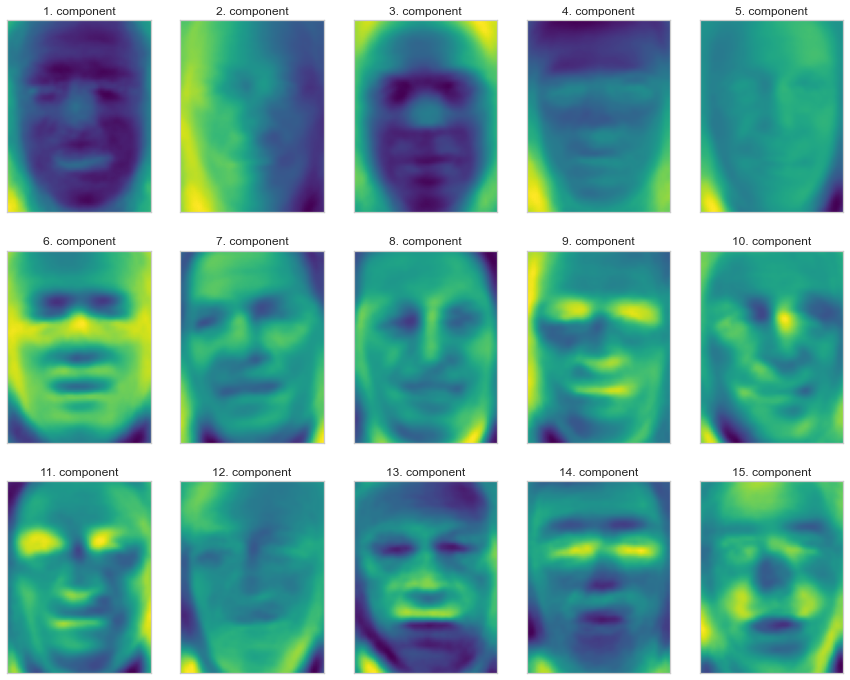

In [ ]:
image_shape = people.images[0].shape

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))